# IMPORTS E INSTALAÇÕES
---

In [ ]:
%pip install -r requirements.txt

In [18]:
from ucimlrepo import fetch_ucirepo # ...

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from keras.utils import to_categorical

# import tensorflow as tf
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout
from keras.optimizers import SGD


# import funcoes_auxiliares as faux
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# FUNÇÕES AUXILIARES
---

In [2]:
def busca_registros_faltantes(df):
    # Verifica quais colunas têm pelo menos um dado faltante
    colunas_com_faltantes = df.columns[df.isnull().any()]

    # Filtra o dataframe original para incluir apenas as colunas com faltantes
    subdataframe = df[colunas_com_faltantes]

    # Verifica quais linhas têm pelo menos um dado faltante no subdataframe
    linhas_com_faltantes = subdataframe.index[subdataframe.isnull().any(axis=1)]

    # Filtra novamente o subdataframe para incluir apenas as linhas com faltantes
    subdataframe = subdataframe.loc[linhas_com_faltantes]

    return subdataframe

def plot_historico(history, title):

  fig, ax = plt.subplots(1,2,figsize=(26,10))

  # Imprime a curva de aprendizado
  ax[0].set_title('Mean Absolute Percentage Error', pad=-40)
  ax[0].plot(history.history['loss'], label='train')
  ax[0].plot(history.history['val_loss'], label='valid')
  ax[0].legend(loc='best')

  # Imprime a curva de acurácia
  ax[1].set_title('Mean Absolute Error', pad=-40)
  ax[1].plot(history.history['mae'], label='train')
  ax[1].plot(history.history['val_mae'], label='valid')
  ax[1].legend(loc='best')

  fig.suptitle(title)

  #fig.savefig('/content/gdrive/MyDrive/Engenharia Elétrica/Deep Learning/' + title)
  #plt.show()

def correlacao_e_visualizacao(dataset, target_column, method='pearson', threshold=0.6):
    # Calcular a correlação
    correlacao = dataset.corrwith(dataset[target_column], method=method)

    # Selecionar colunas com base no limiar de correlação
    colunas_selecionadas = correlacao[(correlacao >= threshold) | (correlacao <= -threshold)].index

    # Criar um DataFrame com as correlações
    correlations = pd.DataFrame({method.capitalize(): correlacao})

    # Criar um mapa de calor com as correlações originais
    sns.set_theme(style='darkgrid')
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    sns.heatmap(data=correlations, annot=True, cmap='coolwarm', fmt=".2f", ax=ax[0])
    ax[0].set_title(f"Correlação com '{target_column}'")

    # Criar um novo DataFrame com as colunas selecionadas
    dataset_filtrado = dataset[colunas_selecionadas]

    # Calcular as correlações para o DataFrame filtrado
    correlacao_filtrada = dataset_filtrado.corrwith(dataset[target_column], method=method)

    # Criar um mapa de calor para as correlações filtradas
    sns.heatmap(data=pd.DataFrame({method.capitalize(): correlacao_filtrada}), annot=True, cmap='coolwarm', fmt=".2f", ax=ax[1])
    ax[1].set_title(f"Correlação de {method.capitalize()} (Filtrada)")

    plt.tight_layout()
    plt.show()

def exibir_metricas_classificacao(classe_teste, previsoes):
    # Calcular métricas
    acuracia = accuracy_score(classe_teste, previsoes)
    precisao = precision_score(classe_teste, previsoes, average="micro")
    recall = recall_score(classe_teste, previsoes, average="micro")
    f1score = f1_score(classe_teste, previsoes, average="micro")

    # Criar um DataFrame para exibir as métricas
    df = pd.DataFrame({
        'Acurácia': [acuracia],
        'Precisão': [precisao],
        'Recall': [recall],
        'F1-Score': [f1score]
    })

    return df

def exibir_matriz_confusao(classe_teste, previsoes):
    matriz = confusion_matrix(classe_teste, previsoes)

    plt.figure(figsize=(6, 4))
    sns.heatmap(matriz, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Previsto')
    plt.ylabel('Verdadeiro')
    plt.title('Matriz de Confusão')
    plt.show()

def plot_loss(history):
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']

    epochs = np.arange(1, len(val_loss_values) + 1)

    plt.plot(epochs, loss_values, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_accuracy(history, metric_name='categorical_accuracy'):
    history_dict = history.history
    acc_values = history_dict[metric_name]
    val_acc_values = history_dict['val_' + metric_name]

    epochs = np.arange(1, len(val_acc_values) + 1)

    plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def normalize_dataset(dataset, columns_to_exclude):
    # Crie um DataFrame com as colunas a serem normalizadas
    df_to_normalize = dataset.drop(columns=columns_to_exclude)
    
    # Realize a normalização Min-Max nas colunas selecionadas
    scaler = MinMaxScaler()
    df_normalized = pd.DataFrame(scaler.fit_transform(df_to_normalize), columns=df_to_normalize.columns)
    
    # Combine o DataFrame normalizado com as colunas originais
    dataset_normalized = pd.concat([df_normalized, dataset[columns_to_exclude]], axis=1)
    
    return dataset_normalized


# EXTRAÇÃO DOS DADOS
---

## Limpeza dos dados

In [3]:
# Buscando de csv local
dataset = pd.read_csv("dados-emprestimo.csv", sep=",")

# Uma descrição estatística dos dados
dataset.isna().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [4]:
# drop price and normalized-losses from features
registro_faltantes = busca_registros_faltantes(dataset)
registro_faltantes

,Gender,Married,Dependents,Self_Employed,LoanAmount,Loan_Amount_Term,Credit_History
0,Male,No,0,No,NaN,360.0,1.0
11,Male,Yes,2,NaN,109.0,360.0,1.0
16,Male,No,1,No,100.0,240.0,NaN
19,Male,Yes,0,NaN,115.0,NaN,1.0
23,NaN,Yes,2,No,112.0,360.0,0.0
...,...,...,...,...,...,...,...
592,NaN,No,3+,Yes,292.0,360.0,1.0
597,Male,No,NaN,No,88.0,360.0,0.0
600,Female,No,3+,NaN,350.0,180.0,NaN
601,Male,Yes,0,NaN,155.0,360.0,1.0


Agora vamos retirar todos os registros que possuem valores faltantes. Essa abordagem é possível pois manteremos uma base de dados interessante após o corte:

$$ \approx 614 - 134 = 480 $$

Além disso, retirarei 'Loan_ID' pois é uma feature que não influencia no resultado.

In [5]:
dataset_filtrado = dataset.dropna(subset=["Gender", "Married", "Dependents", "Self_Employed", "LoanAmount", "Loan_Amount_Term", "Credit_History"]).drop(columns="Loan_ID")

In [6]:
dataset_filtrado

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
5,Male,Yes,2,Graduate,Yes,5417,4196.0,267.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...
609,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


In [7]:
busca_registros_faltantes(dataset_filtrado)

""


## Verificando correlação

Apesar de querer manter o máximo de dados possível, é uma boa pedida fazer a análise de correlação pois queremos manter somente os atributos que tem relevância no diagnóstico. Definirei um ponto de corte para correlação de $\pm0.6$. Deixarei ela parametrizada para que possa ser facilmente modificada.

A Correlação de Pearson é uma métrica muito utilizada para saber o quanto que uma variável numérica interfere ou é inteferida por outra variável de forma linear. E quanto que a correlação de Spearman é utilizada para casos não lineares. Aplicaremos as duas.

> Antes de mais nada, precisamos verificar as estruturas de dados do dataset visto que os métodos de correlação só podem ser feitos com valores *numéricos*.

In [8]:
print(dataset_filtrado.dtypes)

Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object


In [9]:
# Lista das colunas que você deseja codificar
colunas_para_codificar = ['Gender', 'Married', 'Dependents','Education', 'Self_Employed', 'Property_Area', 'Loan_Status']

# Crie um objeto LabelEncoder
label_encoder = LabelEncoder()

# Dataset somente para verificar correlação
dataset_correlacacao = dataset_filtrado.copy()

# Itere pelas colunas e aplique o Label Encoding
for coluna in colunas_para_codificar:
    dataset_correlacacao[coluna] = label_encoder.fit_transform(dataset_correlacacao[coluna])

dataset_correlacacao

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
1,1,1,1,0,0,4583,1508.0,128.0,360.0,1.0,0,0
2,1,1,0,0,1,3000,0.0,66.0,360.0,1.0,2,1
3,1,1,0,1,0,2583,2358.0,120.0,360.0,1.0,2,1
4,1,0,0,0,0,6000,0.0,141.0,360.0,1.0,2,1
5,1,1,2,0,1,5417,4196.0,267.0,360.0,1.0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...
609,0,0,0,0,0,2900,0.0,71.0,360.0,1.0,0,1
610,1,1,3,0,0,4106,0.0,40.0,180.0,1.0,0,1
611,1,1,1,0,0,8072,240.0,253.0,360.0,1.0,2,1
612,1,1,2,0,0,7583,0.0,187.0,360.0,1.0,2,1


Não será necessário utilizar o *'Label encoding'* visto que todos os dados são numéricos. 

Abaixo, utilizarei um método auxiliar 'correlacao_e_visualizacao' que permite fazer a correlação de spearman e pearson, além disso, ela define um 'threshold' que é um limite de corte para a correlação. Nesse caso, o limite foi de 0.4.

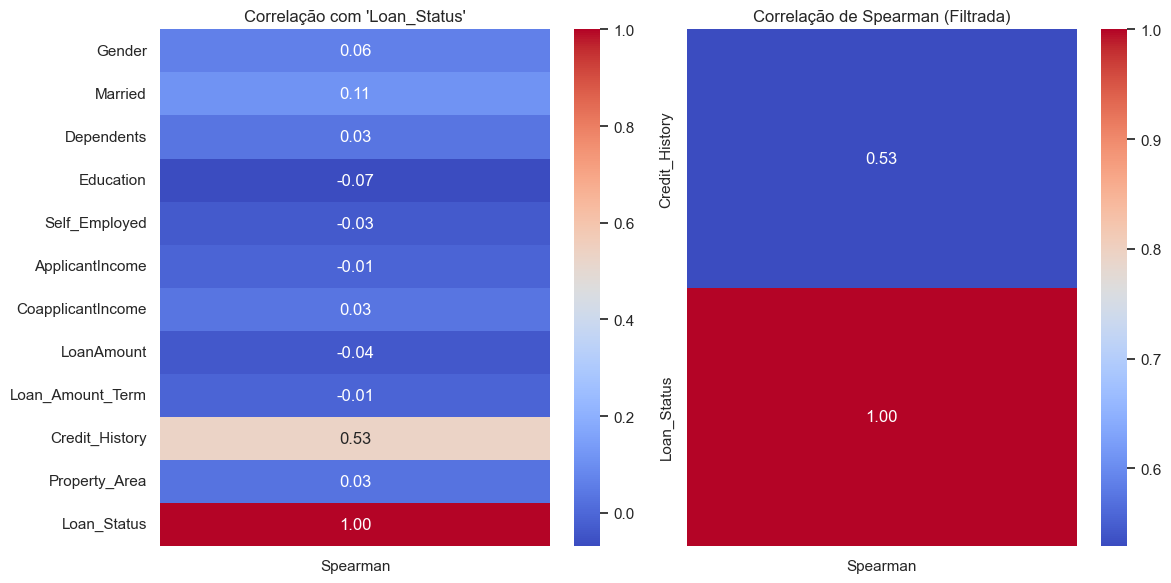

In [10]:
correlacao_e_visualizacao(dataset_correlacacao, 'Loan_Status', method='spearman', threshold=0.4)

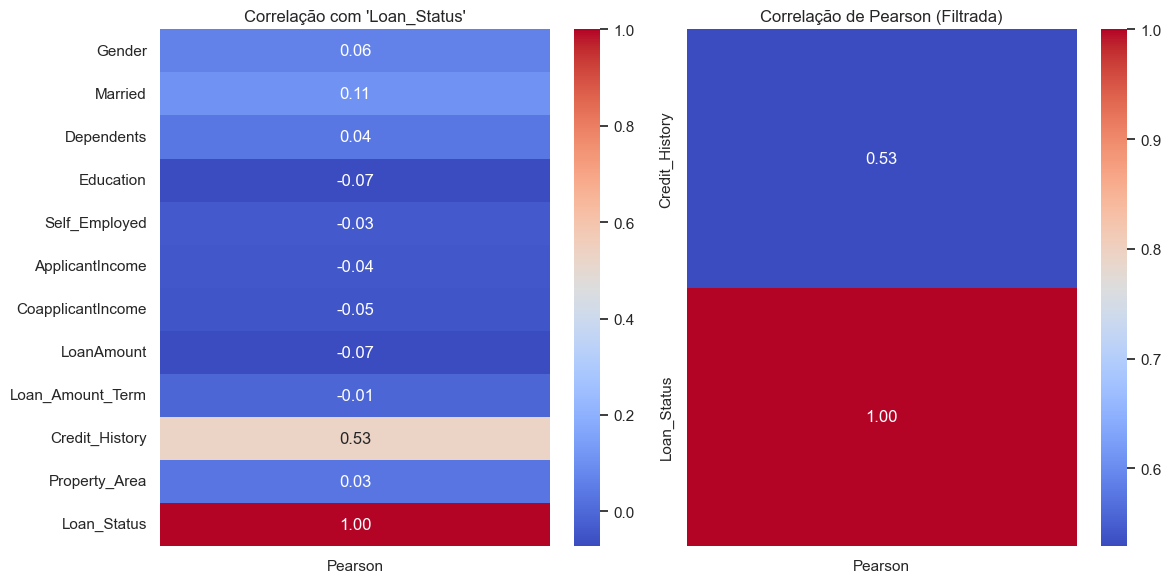

In [11]:
correlacao_e_visualizacao(dataset_correlacacao, 'Loan_Status', method='pearson', threshold=0.4)

Pela análise temos um resultado bastante consistente nos mostrando que é bassicamente o histórico de crédito que influencia a decisão. 

In [13]:
# Lista de colunas que deseja manter
colunas_desejadas = ['Credit_History']

# Sobrescreva o dataset com as colunas desejadas (caso queira usar para algum teste de modelo)
dataset_filtrado_correlacacao = dataset_correlacacao[colunas_desejadas]


# TRANSFORMAÇÃO DOS DADOS
---

## Obtendo Classe e Previsores

In [14]:
# Previsores
X = dataset_filtrado.drop(columns=["Loan_Status"]).values

# Classe
Y = dataset_filtrado["Loan_Status"].values

## Codificação 

In [15]:
labelencoder_classe = LabelEncoder()
Y = labelencoder_classe.fit_transform(Y)

In [16]:
# Fazendo o LabelEncoder dos Previsores que são variáveis nominais
labelencoder_previsores = LabelEncoder()
X[:, 0] = labelencoder_previsores.fit_transform(X[:, 0])    # Gender
X[:, 1] = labelencoder_previsores.fit_transform(X[:, 1])    # Married
X[:, 2] = labelencoder_previsores.fit_transform(X[:, 2])    # Dependents
X[:, 3] = labelencoder_previsores.fit_transform(X[:, 3])    # Education
X[:, 4] = labelencoder_previsores.fit_transform(X[:, 4])    # Self_Employed
X[:, 10] = labelencoder_previsores.fit_transform(X[:, 10])  # Property_Area
X = X.astype('float32')

In [19]:
onehotencorder = ColumnTransformer(transformers=[("OneHot", OneHotEncoder(sparse_output=False), [3, 10])], remainder='passthrough')
X = onehotencorder.fit_transform(X)

## Normalizando

In [20]:
scaler_X = MinMaxScaler()
X = scaler_X.fit_transform(X)

# CARREGANDO DADOS (MODELO)
---

##  Separando Teste e Treino

In [21]:
# Base de treino e teste
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.25)

## Criando modelo

In [22]:
classificador = Sequential()
classificador.add(Dense(units = 2, activation = 'softmax', kernel_initializer = 'random_uniform', input_dim = 14))
classificador.add(Dense(units = 1, activation = 'sigmoid'))

## Compilando o modelo

In [23]:
classificador.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['binary_accuracy'])
classificador.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2)                 30        
                                                                 
 dense_1 (Dense)             (None, 1)                 3         
                                                                 
Total params: 33 (132.00 Byte)
Trainable params: 33 (132.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Treinando o modelo

In [24]:
history = classificador.fit(train_x, train_y, batch_size = 5, epochs = 100, validation_split=0.2)

Epoch 1/100
58/58 [==============================] - 1s 5ms/step - loss: 0.6291 - binary_accuracy: 0.6806 - val_loss: 0.6450 - val_binary_accuracy: 0.6528
Epoch 2/100
58/58 [==============================] - 0s 3ms/step - loss: 0.6218 - binary_accuracy: 0.6806 - val_loss: 0.6446 - val_binary_accuracy: 0.6528
Epoch 3/100
58/58 [==============================] - 0s 3ms/step - loss: 0.6173 - binary_accuracy: 0.6806 - val_loss: 0.6448 - val_binary_accuracy: 0.6528
Epoch 4/100
58/58 [==============================] - 0s 3ms/step - loss: 0.6143 - binary_accuracy: 0.6806 - val_loss: 0.6449 - val_binary_accuracy: 0.6528
Epoch 5/100
58/58 [==============================] - 0s 3ms/step - loss: 0.6123 - binary_accuracy: 0.6806 - val_loss: 0.6453 - val_binary_accuracy: 0.6528
Epoch 6/100
58/58 [==============================] - 0s 3ms/step - loss: 0.6090 - binary_accuracy: 0.6806 - val_loss: 0.6441 - val_binary_accuracy: 0.6528
Epoch 7/100
58/58 [==============================] - 0s 3ms/step - los

# MÉTRICAS E DESEMPENHO
---

In [25]:
# Realizando previsões
previsoes_teste = classificador.predict(test_x)
previsoes_teste = (previsoes_teste > 0.5)

4/4 [==============================] - 0s 4ms/step


In [26]:
exibir_metricas_classificacao(test_y, previsoes_teste)

,Acurácia,Precisão,Recall,F1-Score
0,0.825,0.825,0.825,0.825


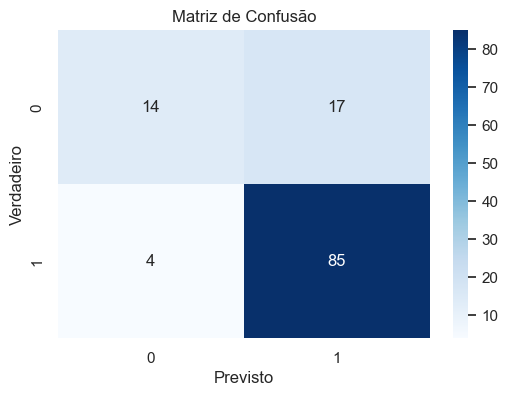

In [27]:
exibir_matriz_confusao(test_y, previsoes_teste)

# EXPORTANDO DADOS
---

In [29]:
import os

# Diretório atual
save_dir = os.getcwd()

# Caminho para os arquivos
arquitetura_path = os.path.join(save_dir, "arquitetura_rede.json")
pesos_path = os.path.join(save_dir, "pesos_rede.h5")

# Salve a arquitetura em JSON
arquitetura = classificador.to_json()
with open(arquitetura_path, "w") as json_file:
    json_file.write(arquitetura)

# Salve os pesos da rede
classificador.save_weights(pesos_path)

print(f"Arquivos salvos em: {save_dir}")

Arquivos salvos em: c:\Users\Mathe\projetos\EoC-AI-IFES\lista3-previsao-emprestimo
